
Analyzing AAPL:


/tmp/ipython-input-3908912618.py:15: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
/tmp/ipython-input-3908912618.py:15: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
/tmp/ipython-input-3908912618.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, start=start_date, progress=False)['Close']


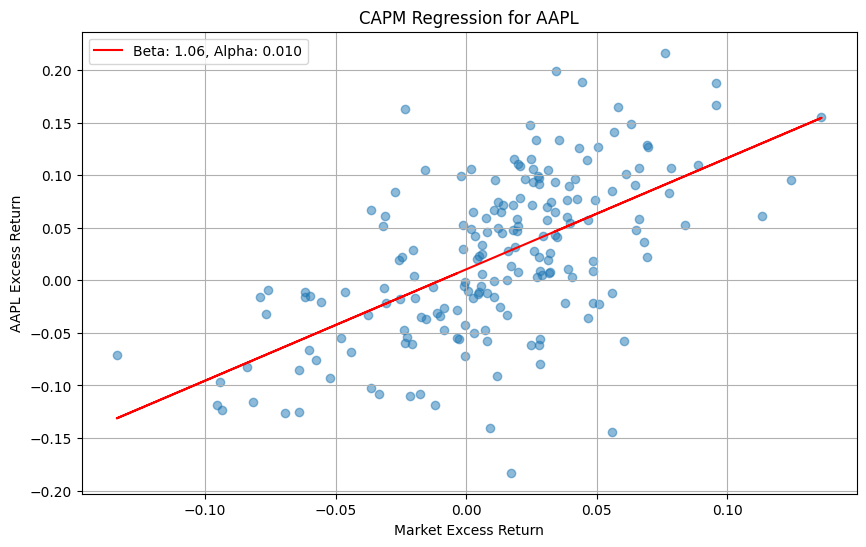

beta: 1.059
alpha: 0.010
r_squared: 0.354
p_value: 0.000
std_err: 0.104

Analyzing MSFT:


/tmp/ipython-input-3908912618.py:15: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
/tmp/ipython-input-3908912618.py:15: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
/tmp/ipython-input-3908912618.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, start=start_date, progress=False)['Close']


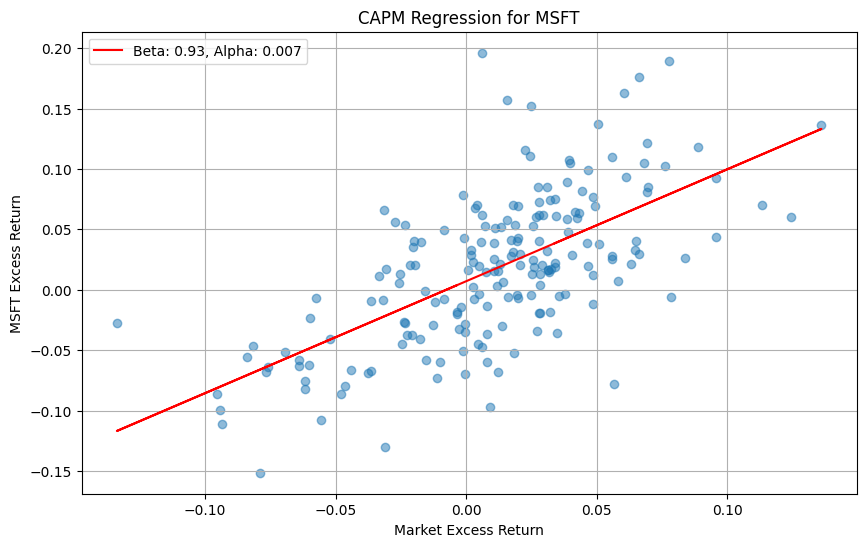

beta: 0.927
alpha: 0.007
r_squared: 0.413
p_value: 0.000
std_err: 0.080

Analyzing GE:


/tmp/ipython-input-3908912618.py:15: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
/tmp/ipython-input-3908912618.py:15: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
/tmp/ipython-input-3908912618.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, start=start_date, progress=False)['Close']


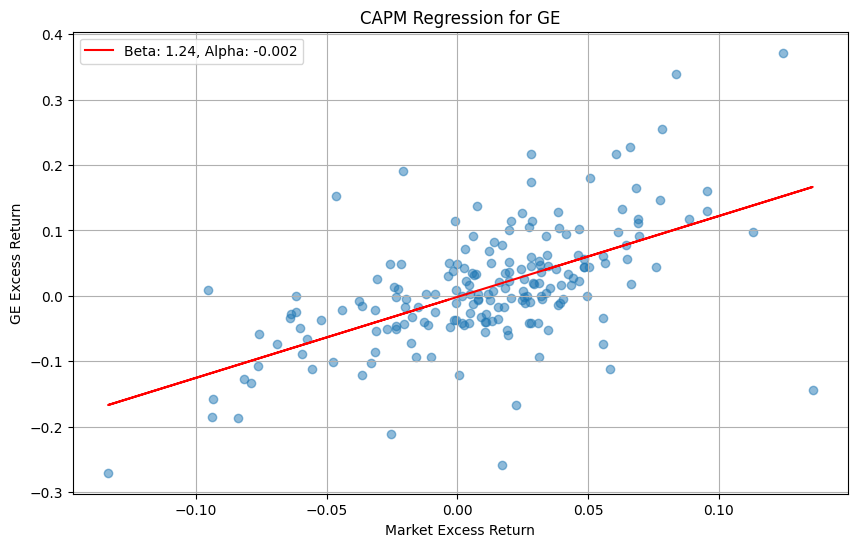

beta: 1.237
alpha: -0.002
r_squared: 0.340
p_value: 0.000
std_err: 0.125


In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pandas_datareader import DataReader as pdr


def estimate_beta(ticker, start_date='2010-01-01'):
    """
    Estimates beta for a given stock using monthly returns.
    """
    # Get Fama-French Data (monthly factors) and convert its index to Timestamps.
    ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
    # Convert the index to Timestamps (we assume these represent month-end dates)
    ff.index = ff.index.to_timestamp('M')
    ff = ff.loc[start_date:]

    # Get stock data and compute monthly returns.
    stock = yf.download(ticker, start=start_date, progress=False)['Close']
    stock_ret = stock.resample('ME').last().pct_change()
    # Convert the Series into a DataFrame so its name ("ret") is kept as a column
    stock_ret = stock_ret[ticker].to_frame(name="ret")
    # Convert its index to Timestamps (month-end) as well
    # Combine the data on the timestamp index.
    df = ff.join(stock_ret, how="inner")

    # Drop any observations that are NaN.
    df = df.dropna()

    # Compute excess returns (subtract risk-free rate).
    df["ret"] = df["ret"] - df["RF"]

    # Run regression: regress stock excess returns on market excess returns.
    beta, alpha, r_value, p_value, std_err = stats.linregress(
        df['Mkt-RF'], df['ret'])

    # Create the regression plot.
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Mkt-RF'], df['ret'], alpha=0.5)
    plt.plot(df['Mkt-RF'], alpha + beta * df['Mkt-RF'], color='red',
             label=f'Beta: {beta:.2f}, Alpha: {alpha:.3f}')
    plt.xlabel('Market Excess Return')
    plt.ylabel(f'{ticker} Excess Return')
    plt.title(f'CAPM Regression for {ticker}')
    plt.legend()
    plt.grid(True)

    return {
        'beta': beta,
        'alpha': alpha,
        'r_squared': r_value**2,
        'p_value': p_value,
        'std_err': std_err
    }


# Example usage:
tickers = ['AAPL', 'MSFT', 'GE']
results = {}
for ticker in tickers:
    print(f"\nAnalyzing {ticker}:")
    results[ticker] = estimate_beta(ticker)
    plt.show()
    for key, value in results[ticker].items():
        print(f"{key}: {value:.3f}")


Analyzing CAPM for GOOGL:


/tmp/ipython-input-3908912618.py:15: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
/tmp/ipython-input-3908912618.py:15: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
/tmp/ipython-input-3908912618.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, start=start_date, progress=False)['Close']


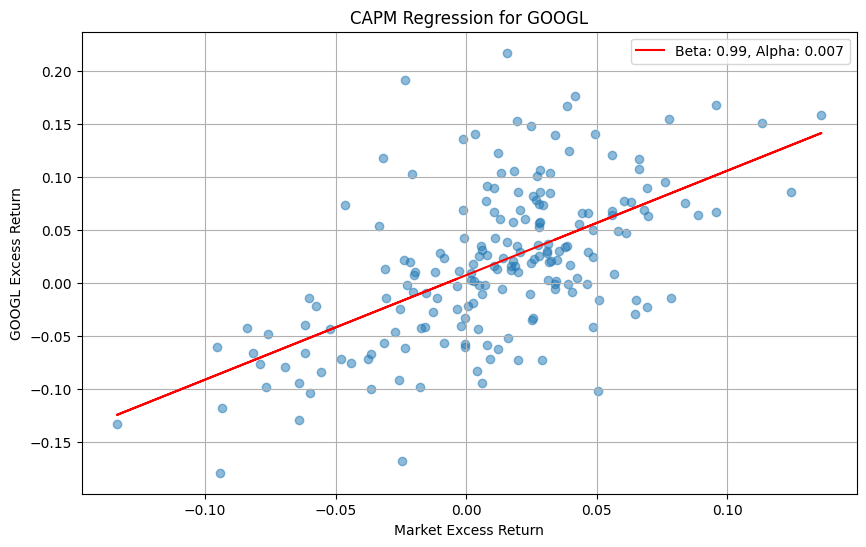

beta: 0.988
alpha: 0.007
r_squared: 0.345
p_value: 0.000
std_err: 0.099

Analyzing CAPM for AMZN:


/tmp/ipython-input-3908912618.py:15: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
/tmp/ipython-input-3908912618.py:15: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
/tmp/ipython-input-3908912618.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, start=start_date, progress=False)['Close']


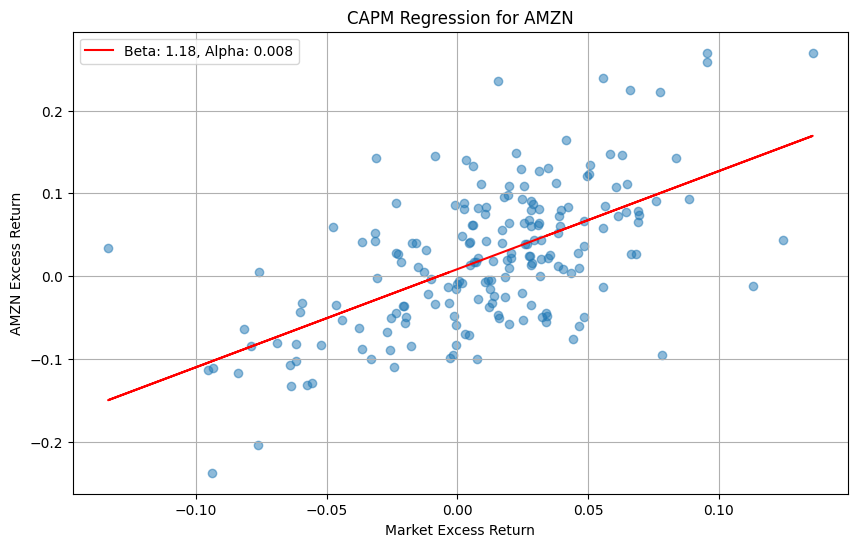

beta: 1.184
alpha: 0.008
r_squared: 0.356
p_value: 0.000
std_err: 0.116


In [15]:
# Calculate CAPM betas and alphas for the same tickers as Fama-French
capm_results = {}
for ticker in tickers_ff:
    print(f"\nAnalyzing CAPM for {ticker}:")
    capm_results[ticker] = estimate_beta(ticker)
    plt.show()
    for key, value in capm_results[ticker].items():
        if not isinstance(value, dict):
            print(f"{key}: {value:.3f}")

In [18]:
import numpy as np

comparison_data = []
for ticker in tickers_ff:
    # CAPM Results
    capm_beta = capm_results[ticker]['beta']
    capm_alpha = capm_results[ticker]['alpha']
    capm_alpha_pvalue = capm_results[ticker]['p_value']

    # Fama-French 3-Factor Results
    ff_beta_mkt_rf = ff_results[ticker]['beta_mkt_rf']
    ff_beta_smb = ff_results[ticker]['beta_smb']
    ff_beta_hml = ff_results[ticker]['beta_hml']
    ff_alpha = ff_results[ticker]['alpha']
    ff_alpha_pvalue = ff_results[ticker]['p_values']['const']

    comparison_data.append({
        'Ticker': ticker,
        'Model': 'CAPM',
        'Market Beta (CAPM)': capm_beta,
        'Alpha (CAPM)': capm_alpha,
        'Alpha p-value (CAPM)': capm_alpha_pvalue,
        'Market Beta (FF3F)': np.nan,
        'SMB Beta (FF3F)': np.nan,
        'HML Beta (FF3F)': np.nan,
        'Alpha (FF3F)': np.nan,
        'Alpha p-value (FF3F)': np.nan
    })
    comparison_data.append({
        'Ticker': ticker,
        'Model': 'Fama-French 3-Factor',
        'Market Beta (CAPM)': np.nan,
        'Alpha (CAPM)': np.nan,
        'Alpha p-value (CAPM)': np.nan,
        'Market Beta (FF3F)': ff_beta_mkt_rf,
        'SMB Beta (FF3F)': ff_beta_smb,
        'HML Beta (FF3F)': ff_beta_hml,
        'Alpha (FF3F)': ff_alpha,
        'Alpha p-value (FF3F)': ff_alpha_pvalue
    })

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df.set_index(['Ticker', 'Model']).style.format('{:.3f}', na_rep='N/A'))

In [1]:
import statsmodels.api as sm

In [6]:
from pandas_datareader import DataReader as pdr
import statsmodels.api as sm
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def estimate_fama_french_beta(ticker, start_date='2020-01-01'):
    """
    Estimates the 3-Factor Fama-French model betas for a given stock using monthly returns.
    """
    # Get Fama-French Data (monthly factors) and convert its index to Timestamps.
    # Using the same method as in estimate_beta function.
    ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
    ff.index = ff.index.to_timestamp('M')
    ff = ff.loc[start_date:]

    # Get stock data and compute monthly returns.
    stock = yf.download(ticker, start=start_date, progress=False)['Close']
    stock_ret = stock.resample('ME').last().pct_change()
    stock_ret = stock_ret[ticker].to_frame(name="ret")
    # The line `stock_ret.index = stock_ret.index.to_timestamp('M')` was removed as it caused an AttributeError.

    # Combine the data on the timestamp index.
    df = ff.join(stock_ret, how="inner")

    # Drop any observations that are NaN.
    df = df.dropna()

    # Compute excess returns (subtract risk-free rate).
    df["ret"] = df["ret"] - df["RF"]

    # Prepare independent variables (factors)
    X = df[['Mkt-RF', 'SMB', 'HML']]
    y = df['ret']

    # Add a constant to the independent variables for the intercept (alpha)
    X = sm.add_constant(X)

    # Run the multiple linear regression
    model = sm.OLS(y, X).fit()

    # Create a scatter plot of Market Excess Return vs. Stock Excess Return
    # For a 3-factor model, visualizing the regression plane in 2D is challenging.
    # We'll plot against Mkt-RF, showing a simplified regression line where SMB and HML are at their means.
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Mkt-RF'], df['ret'], alpha=0.5, label='Actual Excess Returns')

    # Plot the predicted line based on Mkt-RF, holding SMB and HML constant at their means
    X_plot = np.linspace(df['Mkt-RF'].min(), df['Mkt-RF'].max(), 100)
    y_pred_plot = model.params['const'] + model.params['Mkt-RF'] * X_plot + \
                  model.params['SMB'] * df['SMB'].mean() + model.params['HML'] * df['HML'].mean()
    plt.plot(X_plot, y_pred_plot, color='red', label=f'Regression Line (Mkt-RF, SMB=mean, HML=mean)')

    plt.xlabel('Market Excess Return (Mkt-RF)')
    plt.ylabel(f'{ticker} Excess Return')
    plt.title(f'Fama-French 3-Factor Regression for {ticker}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        'beta_mkt_rf': model.params['Mkt-RF'],
        'beta_smb': model.params['SMB'],
        'beta_hml': model.params['HML'],
        'alpha': model.params['const'],
        'r_squared': model.rsquared,
        'p_values': model.pvalues.to_dict(),
        'std_errs': model.bse.to_dict()
    }


Analyzing Fama-French 3-Factor for GOOGL:


/tmp/ipython-input-3377661599.py:14: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
/tmp/ipython-input-3377661599.py:14: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
/tmp/ipython-input-3377661599.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, start=start_date, progress=False)['Close']


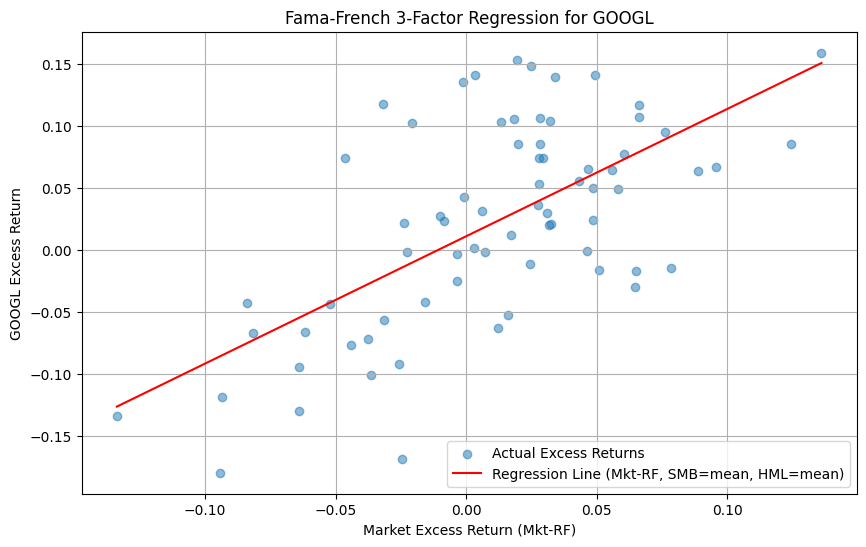

beta_mkt_rf: 1.027
beta_smb: -0.112
beta_hml: -0.291
alpha: 0.011
r_squared: 0.430
p_values: {'const': 0.14790947446000519, 'Mkt-RF': 6.720483844303552e-09, 'SMB': 0.6720996857169941, 'HML': 0.09415544171657941}
std_errs: {'const': 0.0077493827449322756, 'Mkt-RF': 0.15468013581577836, 'SMB': 0.263795244576454, 'HML': 0.17138098020645076}

Analyzing Fama-French 3-Factor for AMZN:


/tmp/ipython-input-3377661599.py:14: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
/tmp/ipython-input-3377661599.py:14: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
/tmp/ipython-input-3377661599.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, start=start_date, progress=False)['Close']


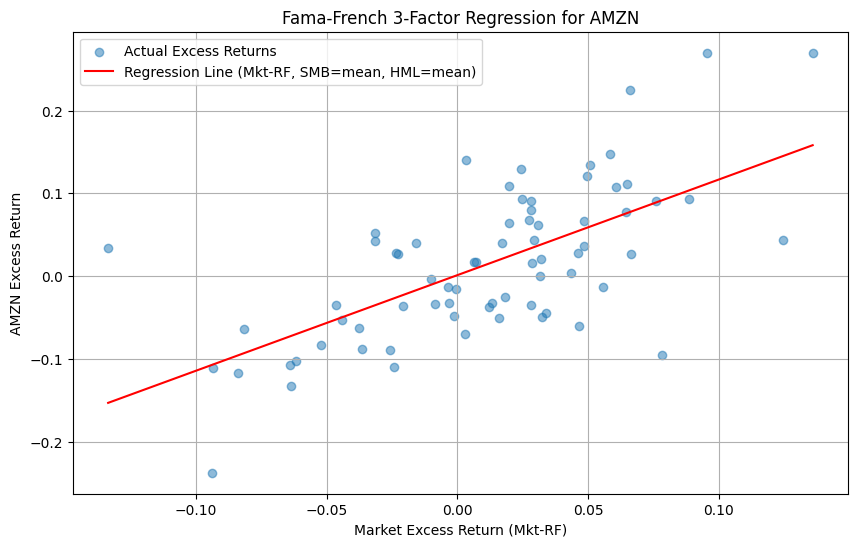

beta_mkt_rf: 1.154
beta_smb: 0.073
beta_hml: -0.950
alpha: 0.003
r_squared: 0.640
p_values: {'const': 0.6886255146551462, 'Mkt-RF': 5.368419068192006e-12, 'SMB': 0.7582501878201351, 'HML': 3.7945474383791474e-08}
std_errs: {'const': 0.006914325163896136, 'Mkt-RF': 0.13801212182032377, 'SMB': 0.2353692103908402, 'HML': 0.15291331749352174}


In [7]:
# Example usage for the Fama-French 3-Factor model:
tickers_ff = ['GOOGL', 'AMZN'] # Using different tickers for Fama-French example
ff_results = {}
for ticker in tickers_ff:
    print(f"\nAnalyzing Fama-French 3-Factor for {ticker}:")
    ff_results[ticker] = estimate_fama_french_beta(ticker)
    for key, value in ff_results[ticker].items():
        if isinstance(value, dict):
            print(f"{key}: {value}")
        else:
            print(f"{key}: {value:.3f}")